# <a name="C1">Importation des données</a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

transactions = pd.read_csv('transactions.csv')
produits = pd.read_csv('products.csv')
clients = pd.read_csv('customers.csv')

In [2]:
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [3]:
clients.shape

(8623, 3)

Il y a 8623 clients, renseignées sur 3 variables différentes : 
- client_id : identifiant du client
- sex : sexe du client
- birth : année de naissance du client

In [4]:
produits.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [5]:
produits.shape

(3287, 3)

Il y a 3287 produits, renseignées sur 3 variables différentes : 
- id_prod : identifiant du produit
- price : prix du produit
- categ : catégorie du produit

In [6]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [7]:
transactions.shape

(337016, 4)

Nous avons 337 016 transactions, renseignées sur 4 variables différentes : 
- id_prod : identifiant du produit
- date : date de la session du client
- session_id : identifiant de la session
- client_id : identifiant du client

In [8]:
transactions.describe(include='all')

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


# <a name="C2">Nettoyage du jeu de données</a>

### 1. Erreurs de type

Vérification que les variables ont bien été importées dans le bon type :

In [9]:
clients.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [10]:
produits.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [11]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Le seul type qui semble incohérent est le type de la variable date qui n'est pas considérée comme une date.

Des données de test empêche la conversion du type de la variable date. Vérification de ces données commençant par "test" dans la variable date :

In [12]:
transactions_test = transactions.loc[transactions.date.str.startswith(
    "test",na = False),:]
transactions_test.describe(include = 'all')

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


In [13]:
transactions_test.client_id.unique()

array(['ct_1', 'ct_0'], dtype=object)

Les transactions contenant "test" dans la variable date correspondent à des clients test "ct_1" et "ct_0", un produit test "T_0" et une session "s_0".
Suppression des 200 lignes de tests dans le dataframe "transactions" afin de ne pas comptabiliser ces données de test dans notre analyse :

In [14]:
# Suppression des 200 lignes de test
transactions = transactions.drop(transactions[transactions.date.str.startswith(
    "test",na = False)].index)

# Transformation du type de donnée de la variable date
transactions['date'] = pd.to_datetime(transactions['date'])
transactions.shape

(336816, 4)

### 2. Vérification existence de données de tests dans les deux autres dataframe

In [15]:
# Recherche des identifiants clients commençant par "ct" au lieu de "c"
clients.loc[clients.client_id.str.startswith("ct",na = False),:]

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


In [16]:
# Suppression des données de tests dans clients
clients = clients.drop(clients[clients.client_id.str.startswith("ct",na = False)].index)
clients.shape

(8621, 3)

In [17]:
# Recherche des identifiants produits commençant par "T" au lieu de de la catégorie du produit
produits.loc[produits.id_prod.str.startswith("T",na = False),:]

,id_prod,price,categ
731,T_0,-1.0,0


In [18]:
# Suppression des données de test dans produits
produits = produits.drop(produits[produits.id_prod.str.startswith("T",na = False)].index)
produits.shape

(3286, 3)

### 3. Doublons 

In [19]:
clients.loc[clients[['client_id', 'sex', 'birth']].duplicated(keep=False),:]

,client_id,sex,birth


In [20]:
clients.loc[clients[['client_id']].duplicated(keep=False),:]

,client_id,sex,birth


In [21]:
produits.loc[produits[['id_prod', 'price', 'categ']].duplicated(keep=False),:]

,id_prod,price,categ


In [22]:
produits.loc[produits[['id_prod']].duplicated(keep=False),:]

,id_prod,price,categ


In [23]:
transactions.loc[transactions[['id_prod', 'date', 'session_id', 'client_id']].duplicated(keep=False),:]

,id_prod,date,session_id,client_id


In [24]:
transactions.loc[transactions[['date','session_id']].duplicated(keep=False),:]

,id_prod,date,session_id,client_id


### 4. Détection d'outliers :

In [25]:
clients.describe(include='all')

,client_id,sex,birth
count,8621,8621,8621.000000
unique,8621,2,NaN
top,c_5846,f,NaN
freq,1,4490,NaN
mean,NaN,NaN,1978.275606
std,NaN,NaN,16.917958
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [26]:
clients.loc[clients.birth<=1931]

,client_id,sex,birth
418,c_5302,m,1929
751,c_4812,m,1931
1086,c_3218,f,1930
2491,c_8362,f,1929
3112,c_4334,m,1931
3994,c_4679,f,1930
4569,c_577,m,1929
4574,c_8350,f,1931
5138,c_7232,f,1930
5988,c_418,f,1931


La valeur minimale de l'année de naissance correspond à des clients âgés de 92 ans, la valeur maximale à 18 ans, ce qui est possible. Nous conservons donc ces données.

array([[<AxesSubplot:title={'center':'birth'}>]], dtype=object)

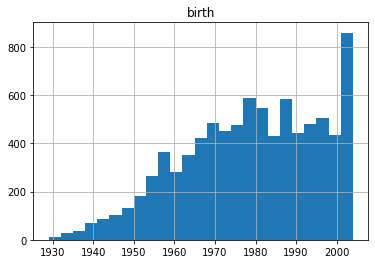

In [27]:
clients.hist(column = 'birth',bins=25)

Il existe un grand nombre de clients avec une date de naissance > 2000.

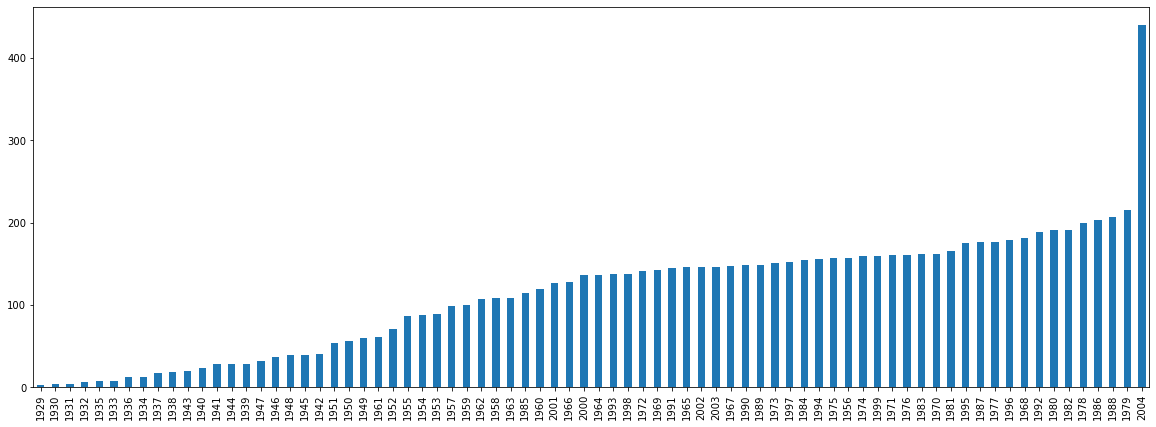

In [28]:
clients["birth"].value_counts(ascending=True).plot(kind='bar',figsize=(20,7))
plt.show()

Il semble qu'un âge < à 18 ans soit impossible dans le SI car il y a une représentation disproportionnée des clients nés en 2004 --> Création d'un découpage en 4 tranches d'âges. 

In [29]:
# Création d'une colonne age
# Année actuelle = 2022
clients["age"] = 2022 - clients.birth

# Identification de 4 groupes d'âges parmis les clients
pd.qcut(clients.age,4)

0       (43.0, 56.0]
1       (43.0, 56.0]
2       (30.0, 43.0]
3       (56.0, 93.0]
4       (56.0, 93.0]
            ...     
8618    (56.0, 93.0]
8619    (43.0, 56.0]
8620    (43.0, 56.0]
8621    (43.0, 56.0]
8622    (30.0, 43.0]
Name: age, Length: 8621, dtype: category
Categories (4, interval[float64]): [(17.999, 30.0] < (30.0, 43.0] < (43.0, 56.0] < (56.0, 93.0]]

In [30]:
# Création d'une colonne classe_age
clients["classe_age"] = pd.cut(clients.age,bins = [15,30,43,56,93])
clients

,client_id,sex,birth,age,classe_age
0,c_4410,f,1967,55,"(43, 56]"
1,c_7839,f,1975,47,"(43, 56]"
2,c_1699,f,1984,38,"(30, 43]"
3,c_5961,f,1962,60,"(56, 93]"
4,c_5320,m,1943,79,"(56, 93]"
...,...,...,...,...,...
8618,c_7920,m,1956,66,"(56, 93]"
8619,c_7403,f,1970,52,"(43, 56]"
8620,c_5119,m,1974,48,"(43, 56]"
8621,c_5643,f,1968,54,"(43, 56]"


In [31]:
produits.describe(include='all')

,id_prod,price,categ
count,3286,3286.000000,3286.000000
unique,3286,NaN,NaN
top,2_9,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.863597,0.370359
std,NaN,29.849786,0.615446
min,NaN,0.620000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.075000,0.000000
75%,NaN,22.990000,1.000000


In [32]:
produits.categ.unique()

array([0, 1, 2])

In [33]:
produits.loc[produits.price > 200]

,id_prod,price,categ
10,2_228,225.17,2
95,2_128,201.74,2
394,2_158,247.22,2
724,2_76,254.44,2
786,2_40,228.11,2
947,2_2,300.00,2
1284,2_211,203.99,2
1436,2_167,236.99,2
1709,2_87,220.99,2
1896,2_4,222.97,2


In [34]:
produits.loc[produits.price < 2]

,id_prod,price,categ
14,0_1938,1.58,0
55,0_686,1.32,0
71,0_1912,1.89,0
93,0_283,1.99,0
145,0_1203,0.99,0
...,...,...,...
3109,0_1171,0.99,0
3137,0_565,1.99,0
3150,0_282,1.57,0
3173,0_238,1.67,0


Les valeurs minimales et maximales des prix semblent possibles. Nous conservons aussi ces données.

In [35]:
transactions.describe(include='all', datetime_is_numeric=True)

,id_prod,date,session_id,client_id
count,336816,336816,336816,336816
unique,3265,NaN,169194,8600
top,1_369,NaN,s_118668,c_1609
freq,1081,NaN,14,12855
mean,NaN,2021-09-03 02:15:11.058526720,NaN,NaN
min,NaN,2021-03-01 00:01:07.843138,NaN,NaN
25%,NaN,2021-05-30 21:13:10.275369728,NaN,NaN
50%,NaN,2021-09-07 05:00:52.682486272,NaN,NaN
75%,NaN,2021-12-08 04:39:47.265316864,NaN,NaN
max,NaN,2022-02-28 23:59:58.040472,NaN,NaN


Les données s'étendent sur une année du 01/03/2021 au 28/02/2022, nous prenons en compte l'ensemble des données en considérant que nous nous situons dans le futur (après le 28/02/2022) pour ce projet.

In [36]:
# Recherche du nombre de transactions par client
transactions.groupby('client_id').count().sort_values('session_id',ascending=False)

,id_prod,date,session_id
client_id,,,
c_1609,12855,12855,12855
c_6714,4473,4473,4473
c_3454,3275,3275,3275
c_4958,2562,2562,2562
c_2140,195,195,195
...,...,...,...
c_5401,1,1,1
c_7089,1,1,1
c_7534,1,1,1


Il existe 4 clients avec un nombre de transaction > 2500 (dont un client avec 12855 transactions), cela peut correspondre à des clients professionnels du secteur (librairies, bibliothèques).

In [37]:
# Vérification que l'ensemble des clients présents dans transactions existent dans clients
client_verif = pd.merge(transactions,clients,
                       on = 'client_id',
                       how = 'left',
                       indicator = True)
client_verif

,id_prod,date,session_id,client_id,sex,birth,age,classe_age,_merge
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,45,"(43, 56]",both
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000,22,"(15, 30]",both
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979,43,"(30, 43]",both
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963,59,"(56, 93]",both
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980,42,"(30, 43]",both
...,...,...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969,53,"(43, 56]",both
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991,31,"(30, 43]",both
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968,54,"(43, 56]",both
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,f,1994,28,"(15, 30]",both


In [38]:
client_verif['_merge'].unique()

['both']
Categories (1, object): ['both']

L'ensemble des identifiants clients "client_id" présents dans la table transactions existent dans la table client.

In [39]:
# Vérification que l'ensemble des produits présents dans transactions existent dans produits
produit_verif = pd.merge(transactions,produits,
                       on = 'id_prod',
                       how = 'left',
                       indicator = True)
produit_verif

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,both
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,both
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,both
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,both
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,both
...,...,...,...,...,...,...,...
336811,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,31.99,1.0,both
336812,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,22.99,0.0,both
336813,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,11.03,0.0,both
336814,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,50.99,2.0,both


In [40]:
produit_verif['_merge'].unique()

['both', 'left_only']
Categories (2, object): ['both', 'left_only']

Il existe un (ou des) produit(s) dans transaction qui n'existe(nt) pas dans le dataframe "produits".

In [41]:
# Sélection des lignes de transactions correspondants au(x) produit(s) non présent(s) dans produits 
produit_verif[produit_verif['_merge']=='left_only']

,id_prod,date,session_id,client_id,price,categ,_merge
6231,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,NaN,left_only
10797,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,NaN,NaN,left_only
14045,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,NaN,NaN,left_only
17480,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,NaN,NaN,left_only
21071,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,NaN,left_only
...,...,...,...,...,...,...,...
322523,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,NaN,NaN,left_only
329226,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,NaN,NaN,left_only
330297,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,NaN,NaN,left_only
335331,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,NaN,NaN,left_only


In [42]:
produit_verif[produit_verif['_merge']=='left_only'].id_prod.unique()

array(['0_2245'], dtype=object)

Le produit d'identifiant "0_2245" n'existe pas dans la table produit, la catégorie est "0" (début de l'identifiant du produit) mais nous ne connaissons pas le prix.

In [43]:
produits[produits.id_prod.str.startswith("0_224",na = False)].sort_values('id_prod')

,id_prod,price,categ
1273,0_224,12.51,0
2552,0_2240,3.67,0
2482,0_2241,10.99,0
1303,0_2242,31.79,0
2815,0_2243,8.99,0
1725,0_2244,8.37,0
388,0_2246,6.30,0
778,0_2247,2.99,0
3211,0_2248,19.58,0
331,0_2249,2.99,0


In [44]:
# Ajout du produit "0_2245" à la table produits avec la catégorie "0" et le prix moyen de la catégorie 0
produits = produits.append({'id_prod' : '0_2245', 
                 'price' : produits.loc[produits.categ == 0].price.mean(),
                 'categ' : 0},
                ignore_index=True)
produits.loc[produits.id_prod == '0_2245',:]

,id_prod,price,categ
3286,0_2245,11.732795,0


### 5. Valeurs manquantes

In [45]:
clients.isnull().sum()

client_id     0
sex           0
birth         0
age           0
classe_age    0
dtype: int64

In [46]:
produits.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [47]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [48]:
transactions.describe(include="all",datetime_is_numeric=True)

,id_prod,date,session_id,client_id
count,336816,336816,336816,336816
unique,3265,NaN,169194,8600
top,1_369,NaN,s_118668,c_1609
freq,1081,NaN,14,12855
mean,NaN,2021-09-03 02:15:11.058526720,NaN,NaN
min,NaN,2021-03-01 00:01:07.843138,NaN,NaN
25%,NaN,2021-05-30 21:13:10.275369728,NaN,NaN
50%,NaN,2021-09-07 05:00:52.682486272,NaN,NaN
75%,NaN,2021-12-08 04:39:47.265316864,NaN,NaN
max,NaN,2022-02-28 23:59:58.040472,NaN,NaN


Il existe 169194 identifiants de session unique (session_id)

In [49]:
# Vérification sur l'identifiant de session
transactions.sort_values('session_id')

,id_prod,date,session_id,client_id
176588,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
309544,1_635,2021-03-01 00:10:33.163037,s_10,c_2218
42033,0_1451,2021-03-01 04:43:58.025677,s_100,c_3854
148924,0_1030,2021-03-01 04:12:43.572994,s_100,c_3854
328736,0_1590,2021-03-03 02:49:03.169115,s_1000,c_1014
...,...,...,...,...
195828,0_1475,2021-10-04 18:45:05.640783,s_99996,c_4900
91103,0_1197,2021-10-04 18:45:38.003516,s_99997,c_3521
251881,0_1572,2021-10-04 18:45:54.374885,s_99998,c_2795
8129,0_1604,2021-10-04 19:00:20.030388,s_99998,c_2795


In [50]:
# Création colonne num_session sans le "s_" devant l'identifiant de session
transactions['num_session'] = pd.to_numeric(transactions.session_id.str.lstrip('s_'))
transactions.dtypes

id_prod                object
date           datetime64[ns]
session_id             object
client_id              object
num_session             int64
dtype: object

In [51]:
transactions.sort_values('num_session')

,id_prod,date,session_id,client_id,num_session
176588,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,1
95285,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,2
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,3
135986,0_1110,2021-03-01 00:38:57.630675,s_3,c_580,3
157168,0_1638,2021-03-01 00:10:37.223732,s_3,c_580,3
...,...,...,...,...,...
208601,1_456,2022-02-28 23:56:57.196281,s_172422,c_5787,172422
301528,0_1403,2022-02-28 23:59:02.381670,s_172423,c_1460,172423
79892,0_1775,2022-02-28 23:59:58.040472,s_172423,c_1460,172423
242599,1_370,2022-02-28 23:56:57.561424,s_172423,c_1460,172423


L'incrémentation de l'identifiant du numéro de session va jusqu'à la valeur 172424 alors qu'il n'y a que 169194 valeurs uniques de session dans transaction, il manquerait donc 3230 sessions.

In [52]:
# Recherche des identifiants de sessions manquants
all_id = pd.DataFrame(data={'num_session': range(172425)})
all_id = all_id.drop(0)

sessions_manquantes = pd.merge(all_id,transactions, 
                               on = "num_session",
                               how = "left",
                               indicator = True)
sessions_manquantes[sessions_manquantes['_merge']== 'left_only'].sort_values('num_session')

,num_session,id_prod,date,session_id,client_id,_merge
196698,98674,NaN,NaT,NaN,NaN,left_only
196701,98676,NaN,NaT,NaN,NaN,left_only
196702,98677,NaN,NaT,NaN,NaN,left_only
196704,98679,NaN,NaT,NaN,NaN,left_only
196706,98681,NaN,NaT,NaN,NaN,left_only
...,...,...,...,...,...,...
216725,111087,NaN,NaT,NaN,NaN,left_only
216726,111088,NaN,NaT,NaN,NaN,left_only
216730,111092,NaN,NaT,NaN,NaN,left_only
216732,111094,NaN,NaT,NaN,NaN,left_only


Les identifiants de sessions manquants se situent après 98673 et avant 111102. Recherche des dates qui correspondent aux sessions s_98673 et s_111102

In [53]:
transactions.date[transactions.session_id=='s_98673']

72312    2021-10-02 00:38:08.182183
129339   2021-10-02 00:05:47.543741
Name: date, dtype: datetime64[ns]

In [54]:
transactions.date[transactions.session_id=='s_111102']

202576   2021-10-28 00:22:07.639865
Name: date, dtype: datetime64[ns]

Les sessions manquantes sont comprises entre le 2 et le 28/10/2021, elles se situent donc toute au cours du mois d'octobre.

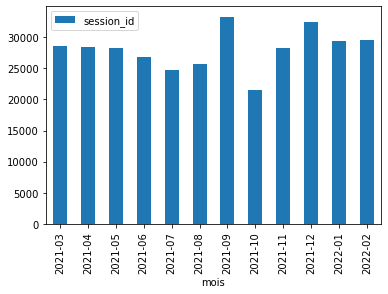

En moyenne, il y a 28657 sessions par mois. Avec 3230 sessions manquantes, il manque environ 11 % des sessions sur le mois d'octobre.


In [55]:
# Création d'une colonne mois à partir de la colonne "date"
transactions["mois"]= transactions['date'].dt.to_period('M')

# Pivot afin d'obtenir le nombre de session par mois
nbsessions_mois = transactions.pivot_table(
    index=["mois"],
    values = 'session_id',
    aggfunc = 'count')

# Affichage d'un diagramme en bâton représentant le nombre de sessions par mois
nbsessions_mois.plot(kind='bar')
plt.show()
nbsessions_mois.reset_index(inplace=True)

# Calcul du nombre de sessions moyen par mois en excluant les sessions du mois d'octobre
mean_sessions_mois = int(nbsessions_mois[nbsessions_mois.mois!= '2021-10'].session_id.mean())

print("En moyenne, il y a", 
      mean_sessions_mois,
      'sessions par mois. Avec 3230 sessions manquantes, il manque environ',
      int(3230 * 100/mean_sessions_mois),
     "% des sessions sur le mois d'octobre.")

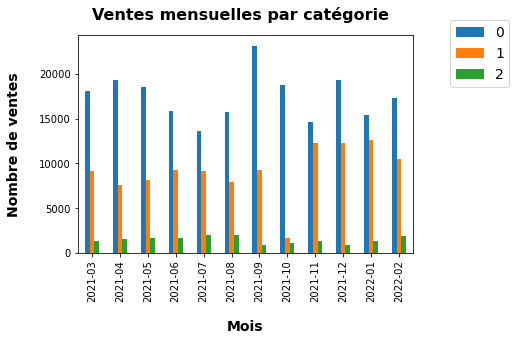

In [56]:
# Jointure entre transactions et produits
transactions = pd.merge(transactions,produits,
                       on = 'id_prod',
                       how = 'inner')

# Pivot pour obtenir par mois le nombre de transaction par catégorie de produits
produit_categ = transactions.pivot_table(
    index=["mois"],
    values = "id_prod", 
    columns = "categ",
    aggfunc = 'count')

# Graphique avec le nombre de transactions par mois et par catégorie
produit_categ.plot(kind='bar')
plt.suptitle("Ventes mensuelles par catégorie",fontsize=16,fontweight='bold')
plt.xlabel('Mois',fontsize=14,fontweight='bold',labelpad=18)
plt.ylabel('Nombre de ventes',fontsize=14,fontweight='bold',labelpad=18)
plt.legend(loc="lower center", bbox_to_anchor=(1.2,0.73),fontsize=14)
plt.savefig("Ventes mensuelles par catégorie 1.png",bbox_inches='tight')
plt.show()

In [57]:
#Sélections des transactions comprises entre le 2/10/2022 et le 28/10/2022
sessions_manquantes = transactions[(transactions.date>'2021-10-02')&(transactions.date<'2021-10-28')]

print(sessions_manquantes.categ.unique())
sessions_manquantes.groupby('categ')['id_prod'].count()

[0 2]


categ
0    15856
2      962
Name: id_prod, dtype: int64

Il manque 3230 transactions et il n'y a aucune transaction de produits de catégorie 1 sur la période du 3/10/2022 au 27/10/2022.

Les données du mois d'octobre étant trop altérées --> suppression des transactions du mois d'octobre :

In [58]:
transactions = transactions.drop(transactions[transactions.mois == "2021-10"].index)

In [59]:
# Export en fichiers csv pour la partie analyse
transactions.to_csv("ventes.csv",index = False)
clients.to_csv("clients.csv",index = False)
produits.to_csv("produits.csv",index = False)